Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

# Let's wrangle, baby

In [14]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [83]:
import numpy as np

In [35]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv', parse_dates=['Date'])

In [36]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [37]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [38]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [39]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

# Let's get to splitting

In [40]:
# Reindex so we can slice on dates later
df.set_index('Date', inplace=True)

In [41]:
# Separate our target vector from our feature matrix
target = 'Great'
y = df[target]
X = df.drop(columns=target)

In [43]:
# Split along cutoff dates for our train/validate/test sets
cutoff1 = '2017-01-01'
cutoff2 = '2018-01-01'

mask = X.index < cutoff1
mask2 = (X.index >= cutoff1) & (X.index < cutoff2)
mask3 = X.index >= cutoff2

X_train, y_train = X.loc[mask], y.loc[mask]
X_validate, y_validate = X.loc[mask2], y.loc[mask2]
X_test, y_test = X.loc[mask3], y.loc[mask3]

In [ ]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)

# Woo-Hoo, it's *Baseline* time

In [47]:
# Establish our baseline accuracy so we know what we're comparing to
print('Baseline Accuracy Score:', y_train.value_counts(normalize=True).max())

Baseline Accuracy Score: 0.5906040268456376


# Welcome to model building city, population: You

In [49]:
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

In [97]:
# Let's get that pipeline loaded up
model = make_pipeline(
    OneHotEncoder(use_cat_names=True, handle_unknown='ignore'),
    SimpleImputer(strategy='constant', fill_value=0),
    StandardScaler(),
    LogisticRegression()
)

model.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


# Is it hot in here? Nope, we're just checking our metrics

In [93]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_validate, y_validate))
print('Test Accuracy:', model.score(X_test, y_test))

Training Accuracy: 0.9295302013422819
Validation Accuracy: 0.8117647058823529
Test Accuracy: 0.7631578947368421


# Curious what features make the most difference on our predictions?  Me too!

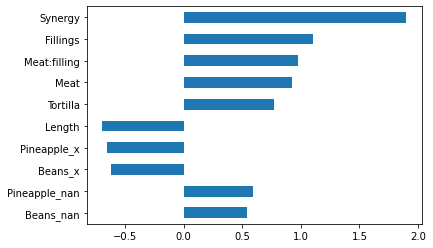

In [112]:
# Create a plot of our coefficients
features = model.named_steps['onehotencoder'].get_feature_names()
coefficients = model.named_steps['logisticregression'].coef_[0]
feat_importance = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_importance.tail(10).plot(kind='barh');